# The Variational Quantum Linear Solver

In [1]:
from qiskit import QuantumCircuit, Aer, transpile, execute
from qiskit.quantum_info import SparsePauliOp, PauliList
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from math import ceil
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
class ClassicalLSSVM:
    def __init__(self, X, y, gamma, kernel:str):
        self.X = X
        self.y = y
        self.gamma = gamma
        self.alpha = np.zeros(len(X))
        self.b = 0
        if kernel == "linearKernel":
            self.kernelFunction = self.linearKernel

    def linearKernel(self,x1, x2):
        return np.dot(x1, x2)

    # Calculate the kernel matrix
    def kernelMatrix(self,X, Y):
        n_samples = X.shape[0]
        m_samples = Y.shape[0]
        K = np.zeros((n_samples, m_samples))
        for i in range(n_samples):
            for j in range(m_samples):
                K[i, j] = self.kernelFunction(X[i], Y[j])
        return K

    def createTopMatrix(self,N):
        matrix_top = np.zeros((N + 1, N + 1))
        matrix_top[0, 0] = 0
        matrix_top[0, 1:] = 1
        matrix_top[1:, 0] = 1
        return matrix_top

    def createBottomMatrix(self,X):
        Omega = self.kernelMatrix(X,X)
        return Omega + np.identity(X.shape[0]) / self.gamma

    def combineTopBottomMatrices(self, X):
        matrix_top = self.createTopMatrix(X.shape[0])
        matrix_bottom = self.createBottomMatrix(X)
        for i in range(matrix_top.shape[0]):
            for j in range(matrix_top.shape[1]):
                if i == 0 or j == 0:
                    continue
                matrix_top[i, j] = matrix_bottom[i-1, j-1]
        return matrix_top

    def weightsAndBiasVector(self,weights, bias):
        return np.concatenate((np.array([bias]), weights))

    def prepareLabels(self,y):
        return np.concatenate((np.array([0]), y))

    def predict(self,X_train, X_test, weights, b):
        ls = self.kernelMatrix(X_test, X_train)
        predictions = np.sign(np.dot(ls, weights) + b)
        return predictions

    def accuracy(self,y_test, predictions):
        return np.sum(np.sign(predictions) == y_test) / len(y_test)


In [3]:
class QuantumSVM:
    def __init__(self, shots = 100000, auxiliaryQubit: int = 0):
        self.auxiliaryQubit = auxiliaryQubit
        self.shots = shots
        self.costHistory = []

    def zGate(self) -> np.array:
        return np.array([[1, 0],
                         [0, -1]])

    def identityGate(self) -> np.array:
        return np.eye(2)

    def setB(self,numQubits: int) -> np.array:# check if this is used anymore
        n = 2**numQubits
        return np.array([float(1/np.sqrt(n)) for _ in range(n)])

    def getApproximationValue(self, A: np.ndarray, b: np.array, o: np.array):
        print(((b.dot(A.dot(o)/(np.linalg.norm(A.dot(o)))))**2).real) # change this to return type

    def plotCost(self):
        plt.style.use("seaborn-v0_8")
        plt.plot(self.costHistory, "g")
        plt.ylabel("Cost function")
        plt.xlabel("Optimization steps")
        plt.show()

    def convertMatrixIntoCircuit(self,circuit: QuantumCircuit, paulis: PauliList, controlled = False, auxiliaryQubit=0, showBarriers = True):
        qubitIndexList = []
        qubits = circuit.num_qubits
        for i in range(qubits):
            if controlled:
                if i != auxiliaryQubit:
                    qubitIndexList.append(i)
            else:
                qubitIndexList.append(i)

        for p in range(len(paulis)):
            for i in range(len(paulis[p])):
                currentGate = paulis[p][i]
                # currentGate = paulis[p][len(paulis[p])-1-i]
                if currentGate.x and currentGate.z == False:
                    if controlled:
                        circuit.cx(auxiliaryQubit, qubitIndexList[i])
                    else:
                        circuit.x(i)
                elif currentGate.x and currentGate.z:
                    if controlled:
                        circuit.cy(auxiliaryQubit, qubitIndexList[i])
                    else:
                        circuit.y(i)
                elif currentGate.z and currentGate.x == False:
                    if controlled:
                        circuit.cz(auxiliaryQubit, qubitIndexList[i])
                    else:
                        circuit.z(i)
            if showBarriers:
                circuit.barrier()

    def getMatrixCoeffitients(self,pauliOp: SparsePauliOp) -> list:
        coeffs = []
        paulis = pauliOp.paulis
        for p in range(len(paulis)):
            containsIdentity = False
            for i in range(len(paulis[p])):
                currentGate = paulis[p][len(paulis[p])-1-i]
                if currentGate.x == False and currentGate.z == False:
                    containsIdentity = True
            coeffs.append(pauliOp.coeffs[p])
            if containsIdentity == False:
                coeffs.append(pauliOp.coeffs[p])
        return coeffs
    
    # VLQS part

    def applyFixedAnsatz(self, circ: QuantumCircuit, qubits: list, parameters: list): #maybe change to 2local or EfficientSU2
        #https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html
        #https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html
        for i in range(len(qubits)):
            circ.ry(parameters[0][i], qubits[i])

        circ.cz(qubits[0], qubits[1])
        circ.cz(qubits[2], qubits[0])

        for i in range(len(qubits)):
            circ.ry(parameters[1][i], qubits[i])

        circ.cz(qubits[1], qubits[2])
        circ.cz(qubits[2], qubits[0])

        for i in range(len(qubits)):
            circ.ry(parameters[2][i], qubits[i])

    # Creates the Hadamard test
    def hadamardTest(self,circ: QuantumCircuit, paulis: PauliList, qubits: list, auxiliaryIndex: int, parameters: list):
        circ.h(auxiliaryIndex)

        circ.barrier()

        self.applyFixedAnsatz(circ, qubits, parameters)

        circ.barrier()

        self.convertMatrixIntoCircuit(circ, paulis, controlled=True, auxiliaryQubit=auxiliaryIndex, showBarriers=False)

        circ.barrier()
        
        circ.h(auxiliaryIndex)
        
    def controlB(self, circ: QuantumCircuit, auxiliaryIndex: int, qubits: list, values: list): 
        custom = self.createB(values).to_gate().control()
        circ.append(custom, [auxiliaryIndex] + qubits)

    def createB(self,values: list) -> QuantumCircuit:
        qubits = ceil(np.log2(len(values)))
        if len(values) != 2**qubits:
            values = np.pad(values, (0, 2**qubits - len(values)), 'constant')
        values = values/np.linalg.norm(values)
        circ = QuantumCircuit(qubits)
        circ.prepare_state(values)
        return circ

    def getBMatrix(self,values:list) -> np.array: # is this used?
        circ = self.createB(values)
        backend = Aer.get_backend('unitary_simulator')
        return execute(circ, backend).result().get_unitary()

    def getBArray(self, values: list) -> np.array:# is this used?
        qubits = ceil(np.log2(len(values)))
        if len(values) != 2**qubits:
            values = np.pad(values, (0, 2**qubits - len(values)), 'constant')
        return np.array(values/np.linalg.norm(values))
    
    # Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test
    def controlFixedAnsatz(self, circ: QuantumCircuit, qubits: list, parameters: list, auxiliaryIndex: int):
        for i in range (len(qubits)):
            circ.cry(parameters[0][i], auxiliaryIndex, qubits[i])

        circ.ccx(auxiliaryIndex, qubits[1], 4)
        circ.cz(qubits[0], 4)
        circ.ccx(auxiliaryIndex, qubits[1], 4)

        circ.ccx(auxiliaryIndex, qubits[0], 4)
        circ.cz(qubits[2], 4)
        circ.ccx(auxiliaryIndex, qubits[0], 4)

        for i in range (len(qubits)):
            circ.cry(parameters[1][i], auxiliaryIndex, qubits[i])

        circ.ccx(auxiliaryIndex, qubits[2], 4)
        circ.cz(qubits[1], 4)
        circ.ccx(auxiliaryIndex, qubits[2], 4)

        circ.ccx(auxiliaryIndex, qubits[0], 4)
        circ.cz(qubits[2], 4)
        circ.ccx(auxiliaryIndex, qubits[0], 4)

        for i in range (len(qubits)):
            circ.cry(parameters[2][i], auxiliaryIndex, qubits[i])

    # Create the controlled Hadamard test, for calculating <psi|psi>
    def specialHadamardTest(self, circ: QuantumCircuit, paulis: PauliList, qubits: list, auxiliaryIndex: int, parameters: list, weights: list):
        circ.h(auxiliaryIndex)

        circ.barrier()

        self.controlFixedAnsatz(circ, qubits, parameters, auxiliaryIndex)

        circ.barrier()

        self.convertMatrixIntoCircuit(circ, paulis, controlled=True, auxiliaryQubit=auxiliaryIndex, showBarriers=False)

        circ.barrier()
        self.controlB(circ, auxiliaryIndex, qubits,weights)
        
        circ.barrier()

        circ.h(auxiliaryIndex)


    # cost functions here
    # Implements the entire cost function on the quantum circuit theoretically
    def calculateCostFunctionMatrix(self,parameters: list, args: list) -> float:
        print ("Iteration:", len(self.costHistory)+1,end="\r")
        overallSum1 = 0
        overallSum2 = 0
        parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]
        paulis = args[0]
        coefficientSet = args[1]
        bVector = args[2]
        totalNumberOfQubits = args[3]
        backend = Aer.get_backend('aer_simulator')

        for i, pauliI in enumerate(paulis):
            for j, pauliJ in enumerate(paulis):
                circ = QuantumCircuit(totalNumberOfQubits, totalNumberOfQubits)
                self.hadamardTest(circ, [pauliI, pauliJ], [1, 2, 3], 0, parameters)
                circ.save_statevector()
                t_circ = transpile(circ, backend)
                job = backend.run(t_circ)

                result = job.result()
                outputstate = np.real(result.get_statevector(circ, decimals=100))
                o = outputstate

                m_sum = 0
                for l in range (len(o)):
                    if (l%2 == 1):
                        n = o[l]**2
                        m_sum+=n

                multiply = coefficientSet[i]*coefficientSet[j]
                overallSum1+=multiply*(1-(2*m_sum))
    
        for i, pauliI in enumerate(paulis):
            for j, pauliJ in enumerate(paulis):
                mult = 1

                for extra in range(2):
                    circ = QuantumCircuit(totalNumberOfQubits, totalNumberOfQubits)

                    if (extra == 0):
                        self.specialHadamardTest(circ, [pauliI], [1, 2, 3], 0, parameters, bVector)
                    if (extra == 1):
                        self.specialHadamardTest(circ, [pauliJ], [1, 2, 3], 0, parameters, bVector)

                    circ.save_statevector()    
                    t_circ = transpile(circ, backend)
                    job = backend.run(t_circ)

                    result = job.result()
                    outputstate = np.real(result.get_statevector(circ, decimals=100))
                    o = outputstate

                    m_sum = 0
                    for l in range (len(o)):
                        if (l%2 == 1):
                            n = o[l]**2
                            m_sum+=n
                    mult = mult*(1-(2*m_sum))

                multiply = coefficientSet[i]*coefficientSet[j]
                overallSum2+=multiply*mult
                
        totalCost = 1-float(overallSum2.real/overallSum1.real)
        self.costHistory.append(totalCost)

        return totalCost

    #Implements the entire cost function on the quantum circuit (sampling, 100000 shots) on the quantum circuit
    def calculateCostFunctionQuantumSimulation(self,parameters: list, args: list) -> float:
        print ("Iteration:", len(self.costHistory)+1,end="\r")
        overallSum1 = 0
        overallSum2 = 0
        parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]
        paulis = args[0]
        coefficientSet = args[1]
        bVector = args[2]
        totalNeededQubits = args[3]
        shots = args[4]

        backend = Aer.get_backend('aer_simulator')
        
        for i, pauliI in enumerate(paulis):
            for j, pauliJ in enumerate(paulis):
                circ = QuantumCircuit(totalNeededQubits,1)
                self.hadamardTest(circ, [pauliI, pauliJ], [1, 2, 3], 0, parameters)
                circ.measure(0, 0)

                t_circ = transpile(circ, backend)
                job = backend.run(t_circ, shots=shots)

                result = job.result()
                outputstate = result.get_counts(circ)

                if ('1' in outputstate.keys()):
                    m_sum = float(outputstate["1"])/shots
                else:
                    m_sum = 0

                multiply = coefficientSet[i]*coefficientSet[j]
                overallSum1+=multiply*(1-2*m_sum)


        for i, pauliI in enumerate(paulis):
            for j, pauliJ in enumerate(paulis):
                mult = 1
                for extra in range(2):
                    circ = QuantumCircuit(totalNeededQubits,1)

                    if (extra == 0):
                        self.specialHadamardTest(circ,[pauliI], [1, 2, 3], 0, parameters, bVector)
                    if (extra == 1):
                        self.specialHadamardTest(circ,[pauliJ], [1, 2, 3], 0, parameters, bVector)

                    circ.measure(0, 0)

                    t_circ = transpile(circ, backend)
                    job = backend.run(t_circ, shots=shots)

                    result = job.result()
                    outputstate = result.get_counts(circ)

                    if ('1' in outputstate.keys()):
                        m_sum = float(outputstate["1"])/shots
                    else:
                        m_sum = 0

                    mult = mult*(1-2*m_sum)
                
                multiply = coefficientSet[i]*coefficientSet[j]
                overallSum2+=multiply*mult
                
        totalCost = 1-float(overallSum2.real/overallSum1.real)
        self.costHistory.append(totalCost)
        return totalCost
    
    # test and minimization functions here
    def ansatzTest(self,circ: QuantumCircuit, outF: list):
        self.applyFixedAnsatz(circ, [0, 1, 2], outF)
        circ.save_statevector()

        backend = Aer.get_backend('aer_simulator')

        t_circ = transpile(circ, backend)
        job = backend.run(t_circ)

        result = job.result()
        return result.get_statevector(circ, decimals=10)

    def minimization(self, paulis: PauliList, coefficientSet: list, totalNeededQubits: int, bVector: list, quantumSimulation:bool = True, method:str = "COBYLA") -> list:
        self.costHistory = []
        x = [float(random.randint(0,3000)) for _ in range(0, 9)]
        x = x/np.linalg.norm(x)
        if quantumSimulation:
            out = minimize(self.calculateCostFunctionQuantumSimulation, x0=x, args=[paulis, coefficientSet, bVector, totalNeededQubits, self.shots], method=method, options={'maxiter':200})
        else:
            out = minimize(self.calculateCostFunctionMatrix, x0=x, args=[paulis, coefficientSet, bVector, totalNeededQubits], method=method, options={'maxiter':200})
        print(out)
        return [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

In [18]:
auxiliaryQubit = 0
shots = 100000 # 100000
gamma = 0.01 # regularization parameter
testSize = 0.2

In [5]:
svm = QuantumSVM(auxiliaryQubit=auxiliaryQubit, shots=shots)

## 1. Introduction

The Variational Quantum Linear Solver, or the VQLS is a variational quantum algorithm that utilizes VQE in order to solve systems of linear equations more efficiently than classical computational algorithms. Specifically, if we are given some matrix $\textbf{A}$, such that $\textbf{A} |\textbf{x}\rangle \ = \ |\textbf{b}\rangle$, where $|\textbf{b}\rangle$ is some known vector, the VQLS algorithm is theoretically able to find a normalized $|x\rangle$ that is proportional to $|\textbf{x}\rangle$, which makes the above relationship true.

The output of this algorithm is identical to that of the HHL Quantum Linear-Solving Algorithm, except, while HHL provides a much more favourable computation speedup over VQLS, the variational nature of our algorithm allows for it to be performed on NISQ quantum computers, while HHL would require much more robust quantum hardware, and many more qubits.


## 2. The Algorithm

To begin, the inputs into this algorithm are evidently the matrix $\textbf{A}$, which we have to decompose into a linear combination of unitaries with complex coefficients:



$$A \ = \ \displaystyle\sum_{n} c_n \ A_n$$



Where each $A_n$ is some unitary, and some unitary $U$ that prepares state $|\textbf{b}\rangle$ from $|0\rangle$. Now, recall the general structure of a variational quantum algorithm. We have to construct a quantum cost function, which can be evaluated with a low-depth parameterized quantum circuit, then output to the classical optimizer. This allows us to search a parameter space for some set of parameters $\alpha$, such that $|\psi(\alpha)\rangle \ = \ \frac{|\textbf{x}\rangle}{|| \textbf{x} ||}$, where $|\psi(k)\rangle$ is the output of out quantum circuit corresponding to some parameter set $k$.

Before we actually begin constructing the cost function, let's take a look at a "high level" overview of the sub-routines within this algorithm, as illustrated in this image from the original paper:

![alt text](images/bro.png)

So essentially, we start off with a qubit register, with each qubit initialized to $|0\rangle$. Our algorithm takes its inputs, then prepares and evaluates the cost function, starting with the creation of some ansatz $V(\alpha)$. If the computed cost is greater than some parameter $\gamma$, the algorithm is run again with updated parameters, and if not, the algorithm terminates, and the ansatz is calculated with the optimal parameters (determined at termination). This gives us the state vector that minimizes our cost function, and therefore the normalized form of $|\textbf{x}\rangle$.

[(0.5+0j), (0.5+0j), (1+0j), (-1+0j), (-1+0j), -0.5j, 0.5j, 0.5j]


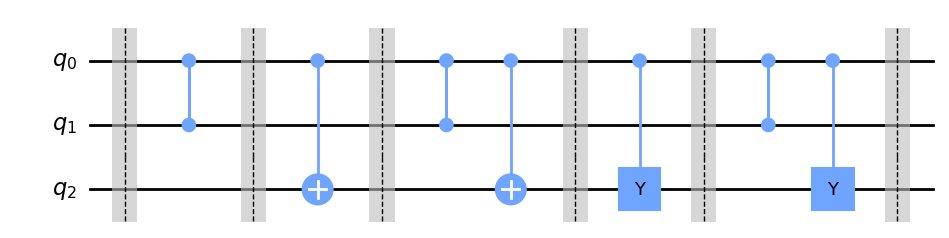

In [6]:
A = np.array([[1, 0, 0, 0],
              [0, 0, 0, 1],
              [0, 0, 1, 0],
              [0, 3, 0, 0]])
pauliOp = SparsePauliOp.from_operator(A)
paulis = pauliOp.paulis
circ = QuantumCircuit(pauliOp.num_qubits+1)

svm.convertMatrixIntoCircuit(circ, paulis, controlled=True, auxiliaryQubit=0)
coefs = svm.getMatrixCoeffitients(pauliOp)
print (coefs)
circ.draw(output="mpl")

[(0.5+0j), (0.5+0j), (1+0j), (-1+0j), (-1+0j), -0.5j, 0.5j, 0.5j]


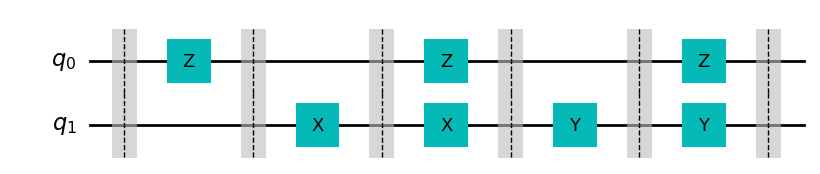

In [7]:
A = np.array([[1, 0, 0, 0],
              [0, 0, 0, 1],
              [0, 0, 1, 0],
              [0, 3, 0, 0]])

pauliOp = SparsePauliOp.from_operator(A)
paulis = pauliOp.paulis
circ = QuantumCircuit(pauliOp.num_qubits)

svm.convertMatrixIntoCircuit(circ, paulis)
coefs = svm.getMatrixCoeffitients(pauliOp)
print (coefs)
circ.draw(output="mpl")

## 3. Qiskit Implementation

### Fixed Hardware Ansatz
Let's start off by considering the ansatz $V(\alpha)$, which is just a circuit that prepares some arbitrary state $|\psi(k)\rangle$. This allows us to "search" the state space by varying some set of parameters, $k$. Anyways, the ansatz that we will use for this implementation is given as follows:

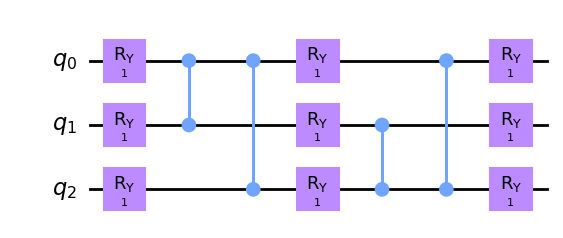

In [8]:
circ = QuantumCircuit(3)
svm.applyFixedAnsatz(circ, [0, 1, 2], [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw(output="mpl")

This is called a **fixed hardware ansatz**: the configuration of quantum gates remains the same for each run of the circuit, all that changes are the parameters. Unlike the QAOA ansatz, it is not composed solely of Trotterized Hamiltonians. The applications of $Ry$ gates allow us to search the state space, while the $CZ$ gates create "interference" between the different qubit states. 

Now, it makes sense for us to consider the actual **cost function**. The goal of our algorithm will be to minimize cost, so when $|\Phi\rangle \ = \ \textbf{A} |\psi(k)\rangle$ is very close to $|\textbf{b}\rangle$, we want our cost function's output to be very small, and when the vectors are close to being orthogonal, we want the cost function to be very large. Thus, we introduce the "projection" Hamiltonian:



$$H_P \ = \ \mathbb{I} \ - \ |b\rangle \langle b|$$



Where we have:



$$C_P \ = \ \langle \Phi | H_P | \Phi \rangle \ = \ \langle \Phi | (\mathbb{I} \ - \ |b\rangle \langle b|) |\Phi \rangle \ = \ \langle \Phi | \Phi \rangle \ - \ \langle \Phi |b\rangle \langle b | \Phi \rangle$$



Notice how the second term tells us "how much" of $|\Phi\rangle$ lies along $|b\rangle$. We then subtract this from another number to get the desired low number when the inner product of $|\Phi\rangle$ and $|b\rangle$ is greater (they agree more), and the opposite for when they are close to being orthogonal. This is looking good so far! However, there is still one more thing we can do to increase the accuracy of the algorithm: normalizing the cost function. This is due to the fact that if $|\Phi\rangle$ has a small norm, then the cost function will still be low, even if it does not agree with $|\textbf{b}\rangle$. Thus, we replace $|\Phi\rangle$ with $\frac{|\Phi\rangle}{\sqrt{\langle \Phi | \Phi \rangle}}$:



$$\hat{C}_P \ = \ \frac{\langle \Phi | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ - \ \frac{\langle \Phi |b\rangle \langle b | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ = \ 1 \ - \ \frac{\langle \Phi |b\rangle \langle b | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ = \ 1 \ - \ \frac{|\langle b | \Phi \rangle|^2}{\langle \Phi | \Phi \rangle}$$



Ok, so, we have prepared our state $|\psi(k)\rangle$ with the ansatz. Now, we have two values to calculate in order to evaluate the cost function, namely $|\langle b | \Phi \rangle|^2$ and $\langle \Phi | \Phi \rangle$. Luckily, a nifty little quantum subroutine called the **Hadamard Test** allows us to do this! Essentially, if we have some unitary $U$ and some state $|\phi\rangle$, and we want to find the expectation value of $U$ with respect to the state, $\langle \phi | U | \phi \rangle$, then we can evaluate the following circuit:

<br><br>

![image1](images/h.png)

<br><br>

Then, the probability of measuring the first qubit to be $0$ is equal to $\frac{1}{2} (1 \ + \ \text{Re}\langle U \rangle)$ and the probability of measuring $1$ is $\frac{1}{2} (1 \ - \ \text{Re}\langle U \rangle)$, so subtracting the two probabilities gives us $\text{Re} \langle U \rangle$. Luckily, the matrices we will be dealing with when we test this algorithm are completely real, so $\text{Re} \langle U \rangle \ = \ \langle U \rangle$, for this specific implementation. Here is how the Hadamard test works. By the circuit diagram, we have as our general state vector:

<br>



$$\frac{|0\rangle \ + \ |1\rangle}{\sqrt{2}} \ \otimes \ |\psi\rangle \ = \ \frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}}$$



<br>

Applying our controlled unitary:

<br>



$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ U|\psi\rangle}{\sqrt{2}}$$



<br>

Then applying the Hadamard gate to the first qubit:

<br>



$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ U|\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{1}{2} \ \big[ |0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle \ + \ |0\rangle \ \otimes \ U|\psi\rangle \ - \ |1\rangle \ \otimes \ U|\psi\rangle \big]$$



<br>



$$\Rightarrow \ \frac{1}{2} |0\rangle \ \otimes \ (\mathbb{I} \ + \ U)|\psi\rangle \ + \ \frac{1}{2} |1\rangle \ \otimes \ (\mathbb{I} \ - \ U)|\psi\rangle$$



<br>

When we take a measurement of the first qubit, remember that in order to find the probability of measuring $0$, we must take the inner product of the state vector with $|0\rangle$, then multiply by its complex conjugate (see the quantum mechanics section if you are not familiar with this). The same follows for the probability of measuring $1$. Thus, we have:

<br>



$$P(0) \ = \ \frac{1}{4} \ \langle \psi | (\mathbb{I} \ + \ U) (\mathbb{I} \ + \ U^{\dagger}) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (\mathbb{I}^2 \ + U \ + \ U^{\dagger} \ + U U^{\dagger}) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (2\mathbb{I} \ + U \ + \ U^{\dagger}) |\psi\rangle$$



<br>



$$\Rightarrow \ \frac{1}{4} \Big[ 2 \ + \ \langle \psi | U^{\dagger} | \psi \rangle \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{4} \Big[ 2 \ + \ (\langle \psi | U | \psi \rangle)^{*} \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{2} (1 \ + \ \text{Re} \ \langle \psi | U | \psi \rangle)$$



<br>

By a similar procedure, we get:

<br>



$$P(1) \ = \ \frac{1}{2} \ (1 \ - \ \text{Re} \ \langle \psi | U | \psi \rangle)$$



<br>

And so, by taking the difference:

<br>



$$P(0) \ - \ P(1) \ = \ \text{Re} \ \langle \psi | U | \psi \rangle$$



<br>

Cool! Now, we can actually implement this for the two values we have to compute. Starting with $\langle \Phi | \Phi \rangle$, we have:

<br>



$$\langle \Phi | \Phi \rangle \ = \ \langle \psi(k) | A^{\dagger} A |\psi(k) \rangle \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} A V(k) |0\rangle \ = \ \langle 0 | V(k)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big) V(k) |0\rangle$$



<br>



$$\Rightarrow \ \langle \Phi | \Phi \rangle \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$$



<br>

and so our task becomes computing every possible term $\langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$ using the Hadamard test. This requires us to prepare the state $V(k) |0\rangle$, and then perform controlled operations with some control-auxiliary qubits for the unitary matrices $A_m^{\dagger}$ and $A_n$. We can implement this in code:


[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1. -0. -0. -0.]
 [ 0.  0.  0.  0. -0. -1. -0. -0.]
 [ 0.  0.  0.  0. -0. -0. -1. -0.]
 [ 0.  0.  0.  0. -0. -0. -0. -1.]]
['ZII']


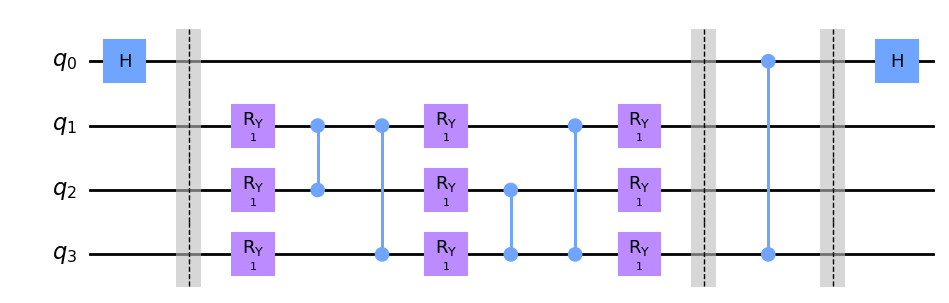

In [9]:
circ = QuantumCircuit(4)
matrix = np.kron(svm.zGate(),np.kron(svm.identityGate(),svm.identityGate()))
pauliOp = SparsePauliOp.from_operator(matrix)

svm.hadamardTest(circ, pauliOp.paulis, [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw(output="mpl")

The reason why we are applying two different "gate_types" is because this represents the pairs of gates shown in the expanded form of $\langle \Phi | \Phi \rangle$.

It is also important to note that for the purposes of this implementation (the systems of equations we will actually be solving, we are only concerned with the gates $Z$ and $\mathbb{I}$, so I only include support for these gates (The code includes number "identifiers" that signify the application of different gates, $0$ for $\mathbb{I}$ and $1$ for $Z$).

Now, we can move on to the second value we must calculate, which is $|\langle b | \Phi \rangle|^2$. We get:

<br>



$$|\langle b | \Phi \rangle|^2 \ = \ |\langle b | A V(k) | 0 \rangle|^2 \ = \ |\langle 0 | U^{\dagger} A V(k) | 0 \rangle|^2 \ = \ \langle 0 | U^{\dagger} A V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$$



<br>

All we have to do now is the same expansion as before for the product $\langle 0 | U^{\dagger} A V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$:

<br>



$$\langle 0 | U^{\dagger} A V(k) | 0 \rangle^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A_m^{\dagger} U |0\rangle$$



<br>

Now, again, for the purposes of this demonstration, we will soon see that all the outputs/expectation values of our implementation will be real, so we have:
<br>



$$\Rightarrow \ \langle 0 | U^{\dagger} A V(k) | 0 \rangle \ = \ (\langle 0 | U^{\dagger} A V(k) | 0 \rangle)^{*} \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$$



<br>

Thus, in this particular implementation:

<br>



$$|\langle b | \Phi \rangle|^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | U^{\dagger} A_m V(k) | 0 \rangle$$



<br>

There is a sophisticated way of solving for this value, using a newly-proposed subroutine called the **Hadamard Overlap Test** (see cited paper), but for this tutorial, we will just be using a standard Hadamard Test, where we control each matrix. This unfortunately requires the use of an extra auxiliary qubit. We essentially just place a control on each of the gates involved in the auxiliary, the $|b\rangle$ preparation unitary, and the $A_n$ unitaries. We get something like this for the controlled-ansatz:


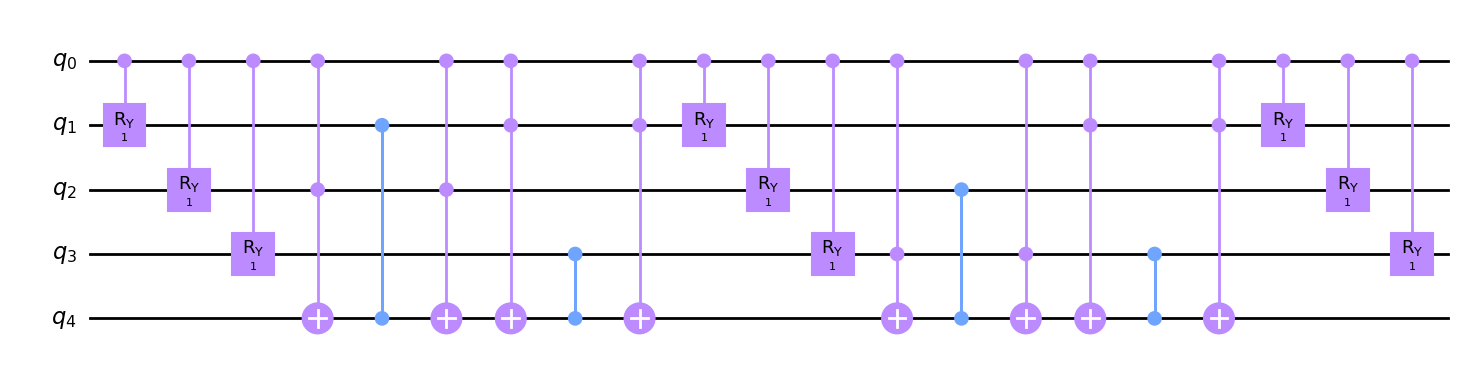

In [10]:
circ = QuantumCircuit(5)
svm.controlFixedAnsatz(circ, [1, 2, 3], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 0)
circ.draw(output="mpl")

Notice the extra qubit, `q0_4`. This is an auxiliary, and allows us to create a $CCZ$ gate, as is shown in the circuit. Now, we also have to create the circuit for $U$. In our implementation, we will pick $U$ as:

<br>



$$U \ = \ H_1 H_2 H_3$$



<br>

Thus, we have:

[0.57735027 0.57735027 0.57735027 0.        ]


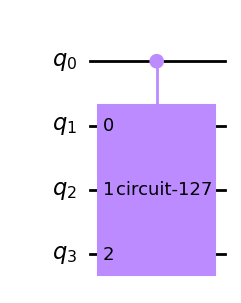

In [11]:
print(svm.getBArray([1, 1, 1]))

circ = svm.createB([1, 1, 1])
circ.draw(output="mpl")

circ = QuantumCircuit(4)
svm.controlB(circ, 0, [1, 2, 3], [1, 1, 1 ,1,1,1,1,1])
circ.draw(output="mpl")

Finally, we construct our new Hadamard test:

[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1. -0. -0. -0.]
 [ 0.  0.  0.  0. -0. -1. -0. -0.]
 [ 0.  0.  0.  0. -0. -0. -1. -0.]
 [ 0.  0.  0.  0. -0. -0. -0. -1.]]
['ZII']


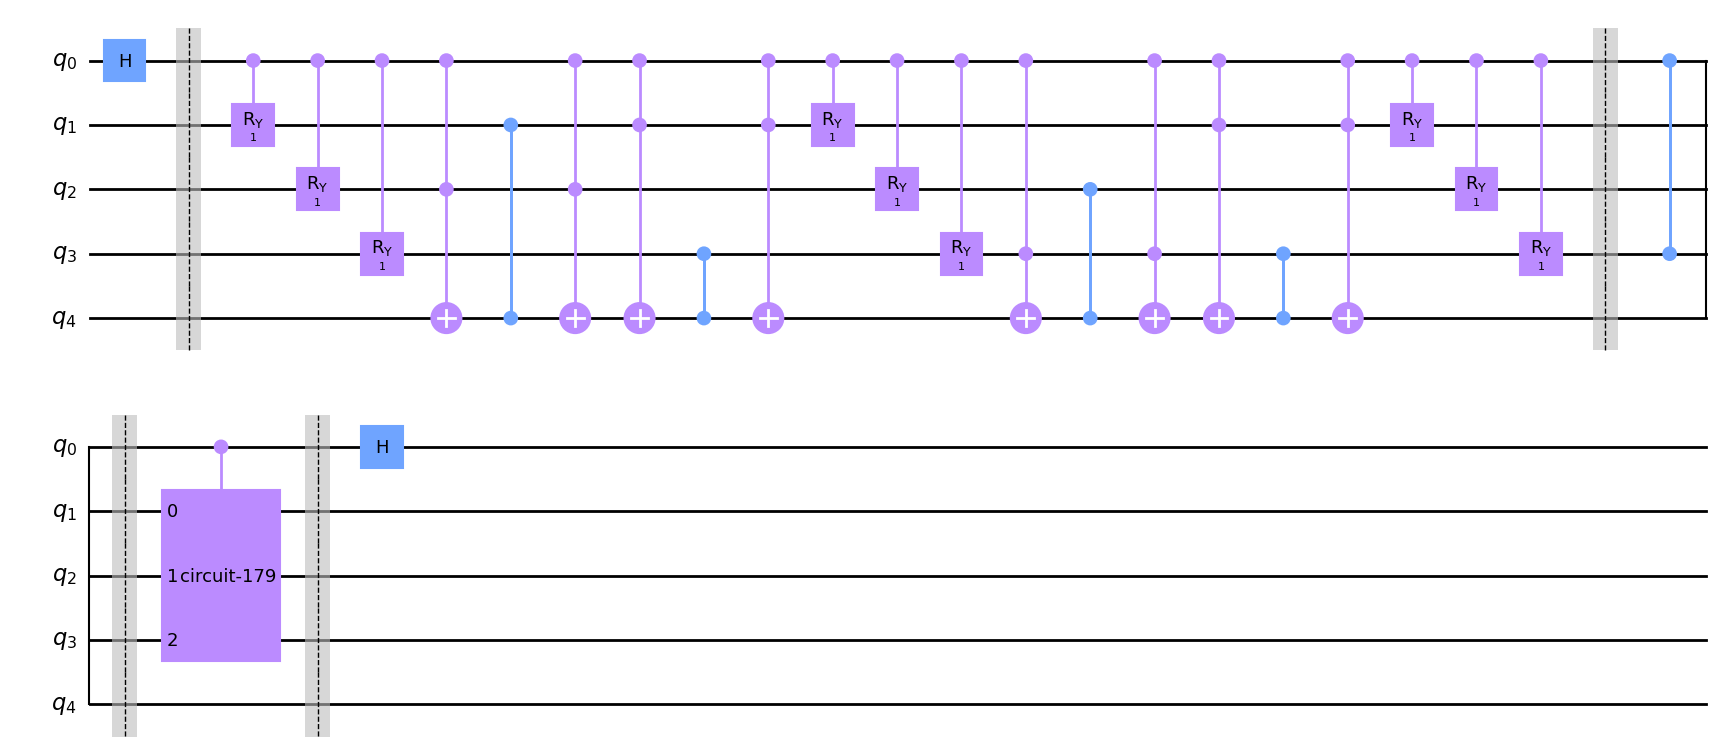

In [12]:
matrix = np.kron(svm.zGate(),np.kron(svm.identityGate(),svm.identityGate()))
circ = QuantumCircuit(5)
svm.specialHadamardTest(circ, pauliOp.paulis, [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]], [1, 1, 1, 1, 1, 1, 1, 1])
circ.draw(output="mpl")

## Move this to the top
Now, we are ready to calculate the final cost function. This simply involves us taking the products of all combinations of the expectation outputs from the different circuits, multiplying by their respective coefficients, and arranging into the cost function that we discussed previously!

## Move this to the top

This code may look long and daunting, but it isn't! In this simulation, I'm taking a **numerical** approach, where I'm calculating the amplitude squared of each state corresponding to a measurement of the auxiliary Hadamard test qubit in the $1$ state, then calculating $P(0) \ - \ P(1) \ = \ 1 \ - \ 2P(1)$ with that information. This is very exact, but is not realistic, as a real quantum device would have to sample the circuit many times to generate these probabilities (I'll discuss sampling later). In addition, this code is not completely optimized (it completes more evaluations of the quantum circuit than it has to), but this is the simplest way in which the code can be implemented, and I will be optimizing it in an update to this tutorial in the near future.

The final step is to actually use this code to solve a real linear system. We will first be looking at the example:

<br>



$$A \ = \ 0.45 Z_3 \ + \ 0.55 \mathbb{I}$$



<br>

In order to minimize the cost function, we use the COBYLA optimizer method, which we repeatedly applying. Our search space for parameters is determined by $\frac{k}{1000} \ k \ \in \ \{0, \ 3000\}$, which is initially chosen randomly. We will run the optimizer for $200$ steps, then terminate and apply the ansatz for our optimal parameters, to get our optimized state vector! In addition, we will compute some post-processing, to see if our algorithm actually works! In order to do this, we will apply $A$ to our optimal vector $|\psi\rangle_o$, normalize it, then calculate the inner product squared of this vector and the solution vector, $|b\rangle$! We can put this all into code as:

[[1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1]]
['III', 'ZII']
[(0.55+0j), (0.44999999999999996+0j)]
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.05794620280906382
       x: [ 7.961e-02  1.365e+00  1.400e+00  4.937e-01  4.660e-01
            1.772e+00 -4.652e-01 -2.149e-02  1.732e-01]
    nfev: 200
   maxcv: 0.0
Statevector([-0.05583814+0.j,  0.05924856+0.j,  0.04955784+0.j,
             -0.04909417+0.j,  0.52686139+0.j, -0.27885853+0.j,
             -0.70824971+0.j,  0.36268835+0.j],
            dims=(2, 2, 2))
[-0.05583814+0.j  0.05924856+0.j  0.04955784+0.j -0.04909417+0.j
  0.05268614+0.j -0.02788585+0.j -0.07082497+0.j  0.03626883+0.j]
[-0.38188405+0.j  0.40520839+0.j  0.33893228+0.j -0.335

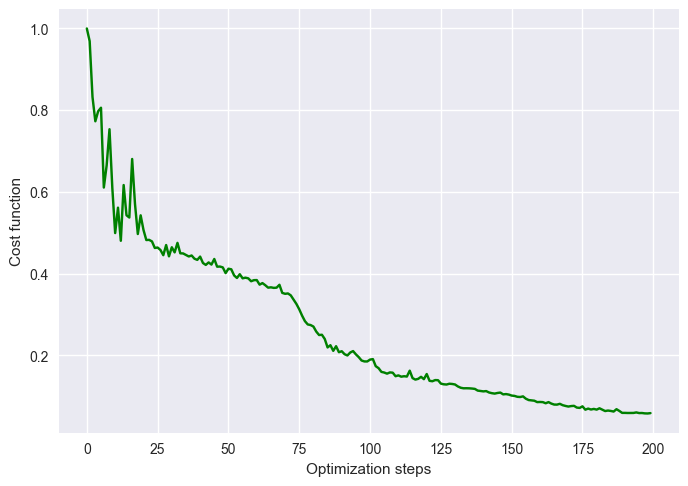

In [13]:
a1 = 0.45*np.kron(svm.zGate(),np.kron(svm.identityGate(),svm.identityGate()))
a2 = 0.55*np.kron(svm.identityGate(),np.kron(svm.identityGate(),svm.identityGate()))
A = np.add(a1, a2)
print(A)

pauliOp = SparsePauliOp.from_operator(A)
paulis = pauliOp.paulis
print (paulis)

coefficientSet = svm.getMatrixCoeffitients(pauliOp)
print (coefficientSet)

bVector = svm.getBArray([1, 1, 1, 1, 1, 1, 1, 1])

outF = svm.minimization(paulis = paulis, coefficientSet = coefficientSet, totalNeededQubits = pauliOp.num_qubits+2, bVector=bVector, quantumSimulation= False)
circ = QuantumCircuit(pauliOp.num_qubits, pauliOp.num_qubits)
o = svm.ansatzTest(circ, outF)

print(o)
print(A.dot(o))
print((A.dot(o)/(np.linalg.norm(A.dot(o)))))
svm.getApproximationValue(A, bVector, o)
svm.plotCost()

As you can see, our cost function has achieved a fairly low value of `0.03273673575407443`, and when we calculate our classical cost function, we get `0.96776862579723`, which agrees perfectly with what we measured, the vectors $|\psi\rangle_o$ and $|b\rangle$ are very similar!

Let's do another test! This time, we will keep $|b\rangle$ the same, but we will have:

<br>



$$A \ = \ 0.55 \mathbb{I} \ + \ 0.225 Z_2 \ + \ 0.225 Z_3$$



Again, we run our optimization code:

[[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.55 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.55 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.55 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.55 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.1  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.1 ]]
['III', 'IZI', 'ZII']
[(0.55+0j), (0.22499999999999998+0j), (0.22499999999999998+0j)]


 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.0031871897637235636
       x: [ 1.390e+00  1.866e+00  1.608e+00  1.613e+00  1.283e-01
            1.570e+00 -1.907e-01 -8.724e-01 -1.003e+00]
    nfev: 200
   maxcv: 0.0
0.0005363978873174633


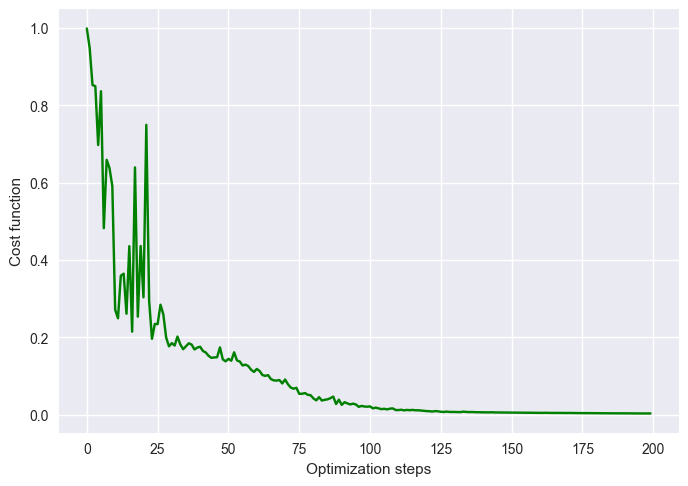

In [14]:
bVector = svm.getBArray([1, 1, 1, 1, 1, 1, 1, 1])

a1 = 0.225*np.kron(svm.zGate(),np.kron(svm.identityGate(),svm.identityGate()))
a0 = 0.225*np.kron(svm.identityGate(),np.kron(svm.zGate(),svm.identityGate()))
a2 =0.55*np.kron(svm.identityGate(),np.kron(svm.identityGate(),svm.identityGate()))
A = np.add(np.add(a2, a0), a1)

print(A)
pauliOp = SparsePauliOp.from_operator(A)
paulis = pauliOp.paulis
print (paulis)

coefficientSet = svm.getMatrixCoeffitients(pauliOp)
print (coefficientSet)

out_f = svm.minimization(paulis=paulis, coefficientSet= coefficientSet, totalNeededQubits=pauliOp.num_qubits+2, bVector=bVector, quantumSimulation=False)
circ = QuantumCircuit(pauliOp.num_qubits,pauliOp.num_qubits)
o = svm.ansatzTest(circ, out_f)

svm.getApproximationValue(A, bVector, o)
svm.plotCost()


Again, very low error, and the classical cost function agrees! Great, so it works!

# move this to the top

Now, we have found that this algorithm works **in theory**. I tried to run some simulations with a circuit that samples the circuit instead of calculating the probabilities numerically. Now, let's try to **sample** the quantum circuit, as a real quantum computer would do! For some reason, this simulation would only converge somewhat well for a ridiculously high number of "shots" (runs of the circuit, in order to calculate the probability distribution of outcomes). I think that this is mostly to do with limitations in the classical optimizer (COBYLA), due to the noisy nature of sampling a quantum circuit (a measurement with the same parameters won't always yield the same outcome). Luckily, there are other optimizers that are built for noisy functions, such as SPSA, but we won't be looking into that in this tutorial. Let's try our sampling for our second value of $A$, with the same matrix $U$:

[[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.55 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.55 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.55 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.55 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.1  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.1 ]]
['III', 'IZI', 'ZII']
[(0.55+0j), (0.22499999999999998+0j), (0.22499999999999998+0j)]
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.11735222204658324
       x: [ 9.293e-01  2.462e+00  1.345e+00  1.447e+00  1.182e-01
            1.852e+00  3.391e-01  2.310e-01  9.603e-02]
    nfev: 107
   maxcv: 0.0
0.00042690788585144886


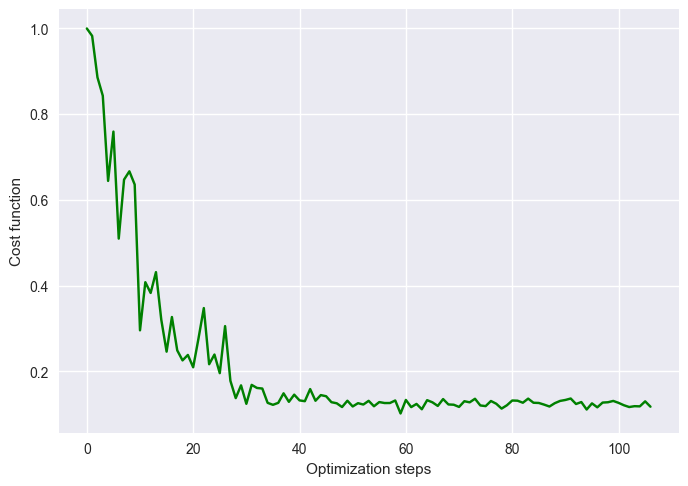

In [15]:
bVector = svm.getBArray([1, 1, 1, 1, 1, 1, 1, 1])

a1 = 0.225*np.kron(svm.zGate(),np.kron(svm.identityGate(),svm.identityGate()))
a0 = 0.225*np.kron(svm.identityGate(),np.kron(svm.zGate(),svm.identityGate()))
a2 =0.55*np.kron(svm.identityGate(),np.kron(svm.identityGate(),svm.identityGate()))
A = np.add(np.add(a2, a0), a1)

print(A)
pauliOp = SparsePauliOp.from_operator(A)
paulis = pauliOp.paulis
print (paulis)

coefficientSet = svm.getMatrixCoeffitients(pauliOp)
print (coefficientSet)

out_f = svm.minimization(paulis=paulis, coefficientSet = coefficientSet, totalNeededQubits = pauliOp.num_qubits+2, bVector = bVector)
circ = QuantumCircuit(pauliOp.num_qubits, pauliOp.num_qubits)
o = svm.ansatzTest(circ, out_f)

svm.getApproximationValue(A, bVector, o)
svm.plotCost()

So as you can see, not amazing, our solution is still off by a fairly significant margin ($~3\%$ error isn't awful, but ideally, we want it to be **much** closer to 0). Again, I think this is due to the optimizer itself, not the actual quantum circuit. I will be making an update to this Notebook once I figure out how to correct this problem (likely with the introduction of a noisy optimizer, as I previously mentioned).

In [16]:
# from qiskit.quantum_info import Operator

# circuit = QuantumCircuit(2)

# cx = Operator([
#     [1, 0, 0, 0],
#     [0, 0, 0, 1],
#     [0, 0, 1, 0],
#     [0, 1, 0, 0]
# ])
# circuit.unitary(cx, [0, 1], label='cx')
# circuit.draw(output="mpl")
# backend = Aer.get_backend('unitary_simulator')
# t_gate = transpile(circuit, backend, basis_gates=['cx', 'u3', 'u1', 'u2', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'cccx', 'cswap'])
# t_gate.draw(output="mpl")
# # execute(circ, backend).result().get_unitary()

LS-SVM Matrix: [[ 0.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.09256230e+02 -3.33994575e+00 ... -2.85908373e+00
   3.94006012e-02 -6.07068684e-01]
 [ 1.00000000e+00 -3.33994575e+00  1.01233536e+02 ...  1.28590519e+00
   2.72769442e-01 -1.35649909e-01]
 ...
 [ 1.00000000e+00 -2.85908373e+00  1.28590519e+00 ...  1.03161318e+02
   2.55930321e+00 -2.99069024e+00]
 [ 1.00000000e+00  3.94006012e-02  2.72769442e-01 ...  2.55930321e+00
   1.02902670e+02 -3.58992127e+00]
 [ 1.00000000e+00 -6.07068684e-01 -1.35649909e-01 ... -2.99069024e+00
  -3.58992127e+00  1.04473571e+02]]
[ 0 -1  1 -1  1  1 -1 -1  1 -1  1  1  1  1  1  1 -1 -1 -1  1 -1 -1 -1  1
 -1  1 -1  1  1  1  1 -1  1 -1  1  1 -1 -1  1  1 -1]
Solution: [ 0.09200202 -0.00629278  0.00708995 -0.00793156  0.00680121  0.00707758
 -0.00966752 -0.00698345  0.00772288 -0.00746978  0.01065457  0.00996635
  0.00694141  0.00696572  0.00605406  0.00564314 -0.01008589 -0.010

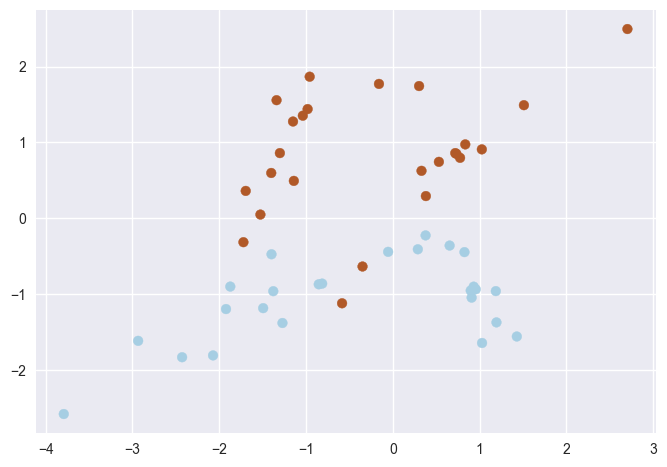

In [19]:
X, y = datasets.make_classification(n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45)
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=42)


lssvm = ClassicalLSSVM(X_train, y_train, gamma, "linearKernel")
# Construct the LS-SVM matrix
lssvm_matrix = lssvm.combineTopBottomMatrices(X_train, gamma)
yVector = lssvm.prepareLabels(y_train)
print("LS-SVM Matrix:", lssvm_matrix)
print(yVector)

# solve the linear system of equations( change this in the future with quantum algorithm)
solution = np.linalg.solve(lssvm_matrix, yVector)
print("Solution:", solution)

bias = solution[0]
weights = solution[1:]

predictions = lssvm.predict(X_train, X_test, weights, bias)
print("Predictions:", predictions)

print("Accuracy:", lssvm.accuracy(y_test, predictions))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

In [ ]:
# from qiskit.circuit.library import EfficientSU2
# from qiskit import QuantumCircuit
# qubits = 2
# ansatz = EfficientSU2(qubits, su2_gates=['ry'], entanglement='circular', reps=qubits -1, insert_barriers=True)
# qc = QuantumCircuit(qubits)  # create a circuit and append the RY variational form
# qc.compose(ansatz, inplace=True)
# #decompose whats inside
# qc.decompose().draw(output="mpl")
# # qc.draw(output="mpl")

In [ ]:
# from qiskit.circuit.library import TwoLocal
# qubits = 4
# ansatz = TwoLocal(qubits, ['ry','cz'], reps=qubits -1, insert_barriers=True)
# qc = QuantumCircuit(qubits)  # create a circuit and append the RY variational form
# qc.compose(ansatz, inplace=True)
# #decompose whats inside
# qc.decompose().draw(output="mpl")

In [ ]:
# import numpy as np
# from qiskit import QuantumCircuit, Aer, transpile, execute
# from qiskit.quantum_info.operators import Operator
# def convertMatrixIntoUnitary(matrix:np.ndarray):
#     Q,_ = np.linalg.qr(matrix)
#     # print(Q)
#     for i in range(Q.shape[1]):
#         Q[:,i] = Q[:,i]/np.linalg.norm(Q[:,i])

#     # print(Q)
#     return Operator(Q)

# def convertUnitaryIntoCircuit(unitary:Operator):
#     return unitary.to_instruction()

# matrix = np.array([[1, 0, 0, 0],
#                      [0, 0, 0, 1],
#                      [0, 0, 1, 0],
#                      [0, 3, 0, 0]])

# unitary = convertMatrixIntoUnitary(matrix)
# circuit = convertUnitaryIntoCircuit(unitary)

# qc = QuantumCircuit(2,2)
# qc.append(circuit, [0, 1])

# backend = Aer.get_backend('unitary_simulator')

# job = execute(qc, backend, shots=8192)
# result = job.result()

# # print(result.get_unitary(circuit, decimals=3))
# qc.decompose().draw(output="mpl")

# # circuit.draw(output="mpl")

In [20]:
X, y = datasets.make_classification(n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45)
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=42)
# randomly select a subset of the training data
subsetSize = 7
subsetIndices = np.random.choice(np.arange(X_train.shape[0]), subsetSize, replace=False)
xSubset = []
ySubset = []
for i in subsetIndices:
    xSubset.append(X_train[i])
    ySubset.append(y_train[i])

xSubset = np.array(xSubset)
ySubset = np.array(ySubset)
lssvm = ClassicalLSSVM(xSubset,ySubset, gamma, "linearKernel")
lssvm_matrix = lssvm.combineTopBottomMatrices(xSubset, gamma)
yVector = lssvm.prepareLabels(ySubset)

print ("LS-SVM Matrix:", lssvm_matrix)

pauliOp = SparsePauliOp.from_operator(lssvm_matrix)
paulis = pauliOp.paulis
print(paulis)

coefficientSet = svm.getMatrixCoeffitients(pauliOp)
print (coefficientSet)

out_f = svm.minimization(paulis=paulis, coefficientSet = coefficientSet, totalNeededQubits = pauliOp.num_qubits+2, bVector = yVector)
circ = QuantumCircuit(pauliOp.num_qubits,pauliOp.num_qubits)
o = svm.ansatzTest(circ, out_f)

svm.getApproximationValue(A, weights, o)
svm.plotCost()

LS-SVM Matrix: [[ 0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.02332217e+02 -3.08600547e+00 -1.11739769e+00
   6.65900043e-01  3.43590655e-01 -1.89225287e+00  1.98327928e-01]
 [ 1.00000000e+00 -3.08600547e+00  1.04217039e+02  3.99083269e-01
  -8.58701256e-01  3.90872973e-02  2.96995654e+00 -5.23744513e-01]
 [ 1.00000000e+00 -1.11739769e+00  3.99083269e-01  1.09256230e+02
  -5.00187473e-01 -4.15339568e+00 -2.85908373e+00  2.01611715e+00]
 [ 1.00000000e+00  6.65900043e-01 -8.58701256e-01 -5.00187473e-01
   1.00193892e+02  1.80955658e-01 -4.62061390e-01  1.27755289e-02]
 [ 1.00000000e+00  3.43590655e-01  3.90872973e-02 -4.15339568e+00
   1.80955658e-01  1.01875017e+02  1.44358797e+00 -9.36380421e-01]
 [ 1.00000000e+00 -1.89225287e+00  2.96995654e+00 -2.85908373e+00
  -4.62061390e-01  1.44358797e+00  1.03161318e+02 -1.07250790e+00]
 [ 1.00000000e+00  1.98327928e-01 -5.23744513e-01  2.0

Statevector([ 0.76656376+0.j, -0.11341127+0.j,  0.01980686+0.j,
              0.40370097+0.j,  0.03671176+0.j,  0.42847371+0.j,
             -0.10442795+0.j, -0.20076958+0.j],
            dims=(2, 2, 2))
[  0.47008451+0.j -11.05543214+0.j   4.10201525+0.j  42.34643214+0.j
   4.09193718+0.j  42.87259837+0.j -11.19599978+0.j -20.47225847+0.j]
0.09323671662837184


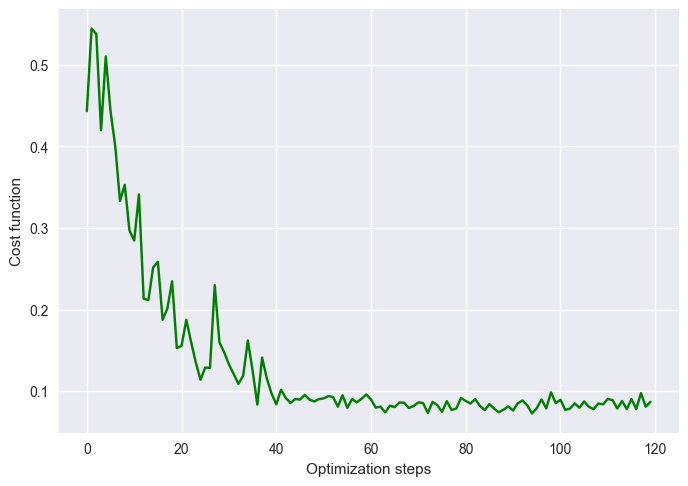

In [ ]:
print (o)
print (lssvm_matrix.dot(o))

svm.getApproximationValue(lssvm_matrix, yVector, o)
svm.plotCost()

In [ ]:
subsetIndicesTest = np.random.choice(np.arange(X_test.shape[0]), subsetSize, replace=False)
xTestSubset = []
yTestSubset = []
for i in subsetIndicesTest:
    xTestSubset.append(X_test[i])
    yTestSubset.append(y_test[i])

xTestSubset = np.array(xTestSubset)
yTestSubset = np.array(yTestSubset)
print(o)
b = o[0]
print(b)
w = []
for i in range (len(o)):
    if (i != 0):
        w.append(o[i])
print (w)
predictions = lssvm.predict(xSubset, xTestSubset, w, b)
print("Predictions:", predictions)
print("Accuracy:", lssvm.accuracy(yTestSubset, predictions))

Statevector([ 0.76656376+0.j, -0.11341127+0.j,  0.01980686+0.j,
              0.40370097+0.j,  0.03671176+0.j,  0.42847371+0.j,
             -0.10442795+0.j, -0.20076958+0.j],
            dims=(2, 2, 2))
(0.7665637615+0j)
[(-0.1134112713+0j), (0.0198068627+0j), (0.4037009725+0j), (0.0367117622+0j), (0.4284737117+0j), (-0.1044279543+0j), (-0.2007695776+0j)]
Predictions: [ 1.+0.j  1.+0.j  1.+0.j -1.+0.j  1.+0.j  1.+0.j  1.+0.j]
Accuracy: 0.5714285714285714
